In [ ]:
%%shell
jupyter nbconvert --to html /content/house_prices_advanced_regression_techniques.ipynb

In [1]:
from prettytable import PrettyTable
import torch
from torch import nn 
from torch.nn import functional as F # for an activation functions such as relu-->F.relu
from torch import optim
from torchvision import datasets, transforms

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn import model_selection
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

import random
import time as time
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore')
global time
# torch.set_printoptions(linewidth=150)



# from IPython.display import display, HTML
# import math
# import torch
# from torch import nn
# import matplotlib.pyplot as plt

# import numpy as np
# import seaborn as sns
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print("""
             ,-._
           _.-'  '--.
         .'      _  -`\_
        / .----.`_.'----' <hello!>
        ;/     `
       /_;

    ._      ._      ._      ._
_.-._)`\_.-._)`\_.-._)`\_.-._)`\_.-._""")

cuda:0

             ,-._
           _.-'  '--.
         .'      _  -`\_
        / .----.`_.'----' <hello!>
        ;/     `
       /_;

    ._      ._      ._      ._
_.-._)`\_.-._)`\_.-._)`\_.-._)`\_.-._


#Reminder for work process 
* Step 1. Define the neural network that has some learnable parameters (or weights)
* Step 2. Iterate over a dataset of inputs
* Step 3. Process input through the network
* Step 4. Compute the loss (how far is the output from being correct)
* Step 5. Propagate gradients back into the network’s parameters
* Step 6. Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate *
* Step 7. Drawing conclusions






[taken from](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

# **1. Load Data**   

* Create transform object that will help to convert the pixels on the dataset to tensors. 
* Image reduction is performed in order to reduce calculation time for identifying the object

![picture](https://drive.google.com//uc?export=view&id=1GBFre06HwBCcuFMvijL0ryYx_97eo-X5)  

[More about Transform & Normalize](https://pytorch.org/vision/stable/transforms.html)

In [2]:
##########################################################
# 1.0 LOAD TRAINNING DATASET
##########################################################
# Define a transform object to normalize the data
image_normalize = lambda x : x / 255.
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(image_normalize)])

data_MNIST = datasets.MNIST('/files/', train = True, download = True, transform = transform)
print(data_MNIST.data.shape)
print(data_MNIST.targets.shape)

##########################################################
# 1.1 SPLIT DATASET TO TRAIN-SET AND VALIDATION-SET
##########################################################
size_val = 0.2
lengths = [int(len(data_MNIST)*(1-size_val)),int(len(data_MNIST)*size_val)]
train_dataset, val_dataset = random_split(data_MNIST, lengths,generator= torch.Generator().manual_seed(42))

##########################################################
# 1.2 DIVIDE DATA TO MINI-BATCH
##########################################################
# shuffle (bool, optional): set to True to have the data reshuffled at every epoch (default: False).
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=50, shuffle=True)
print(f'Number of Mini-Batch on train = {len(train_loader)}\nNumber of Mini-Batch on validation = {len(val_loader)}\nTotal Number of Mini-Batch = {len(train_loader)+len(val_loader)}')

##########################################################
# 1.3 LOAD TEST DATA
##########################################################
# Load MNIST test data
test_loader = torch.utils.data.DataLoader(datasets.MNIST('/files/', 
                                                          train=False, 
                                                          download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), 
                                                          transforms.Lambda(image_normalize)])),                                                      
                                                          batch_size=50, 
                                                          shuffle=True)

torch.Size([60000, 28, 28])
torch.Size([60000])
Number of Mini-Batch on train = 960
Number of Mini-Batch on validation = 240
Total Number of Mini-Batch = 1200


# **2. Create Architectures** 

* *Note- For the task I'll define class that will save all the data of each architecture.*



In [3]:
class Architecture():
  def __init__ (self,model,lr=0.01):
    self.params_success = {'recall':[],'precision':[],'F score':[],'Accuracy':[]} #[train,validation,test]
    self.model = model
    self.model.to(device)
    self.loss_fn = torch.nn.CrossEntropyLoss()
    self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  def make_train_step(self):
    # Builds function that performs a step in the train loop
    def train_step(x, t):
        # Sets model to TRAIN mode
        self.model.train()
        # Makes predictions
        y_pred = self.model(x)
        # Computes loss
        loss = self.loss_fn(y_pred,t)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

  def train_conv(self,train_loader,valid_loader,val_lim,n_epochs = 5):
    start = time.time()
    iter = 1
    acc_val = []
    
    self.Y_predict = []
    self.T = []
    for epoch in range(1, n_epochs + 1):
      ###################
      # train the model #
      ###################
      self.train_architecture(train_loader)
      ######################    
      # validate the model #
      ######################
      self.model.eval()
      with torch.no_grad():
        for  batch_idx, (x,t) in enumerate(valid_loader):
          # setting the model to evaluation mode
          x, t = x.to(device), t.to(device)

          y_predict = self.model(x)
          for i in torch.argmax(y_predict,1):
            self.Y_predict.append(i.item())
          for i in t:
            self.T.append(i.item())

      value = accuracy_score(self.T,self.Y_predict)
      acc_val.append(value)
      if(acc_val[iter-1]>=val_lim):
        break
      print(f'epoch = {epoch},acc_val_last = {value},val_limit = {val_lim}\n')
      self.Y_predict = []
      self.T = []
      iter+=1
        
    train_time = time.time()-start
    return train_time,iter,acc_val
    
  def train_architecture(self,x_data:DataLoader,n_batch = 13000):
    # Creates the train_step function for our model, loss function and optimizer
    train_step = self.make_train_step()
    t_start = time.time()
    batch_counter = 0
    # For each epoch... TRAIN LOOP
    # while batch_counter <= n_batch:
    for batch_idx, (images, labels) in enumerate(x_data):
    # Performs one train step and returns the corresponding loss,acc,recall,precision,f_score
      images, labels = images.to(device), labels.to(device)
      loss = train_step(images, labels)
      if (batch_counter > n_batch):
        break
      batch_counter+=1
      # print(f'epoch {epoch} completed\n')

    self.train_time = time.time()-t_start
    
  def count_parameters(self):
    self.total_params = 0
    self.bias_params = 0
    for name, parameter in self.model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        if "bias" in name:
          self.bias_params+=param
        self.total_params+=param

  #after train we want to do prediction for valdtaion data (in trainning mode) or test data (on test mode)
  def predict(self,test_data):
    self.Y_predict = []
    self.T = []
    with torch.no_grad():
      for  batch_idx, (x,t) in enumerate(test_data):
        # setting the model to evaluation mode
        x, t = x.to(device), t.to(device)
        self.model.eval()

        y_predict = self.model(x)
        for i in torch.argmax(y_predict,1):
          self.Y_predict.append(i.item())
        for i in t:
          self.T.append(i.item())
    self.score()

  def score(self):
    #Documentation of success params

    # accuracy: (tp + tn) / (p + n) OR 
    acc = accuracy_score(self.T,self.Y_predict)
    # precision tp / (tp + fp) OR 
    precision = precision_score(self.T,self.Y_predict,average='macro') 
    # recall: tp / (tp + fn) OR
    recall = recall_score(self.T,self.Y_predict,average='macro')
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(self.T,self.Y_predict,average='macro')
    self.params_success['recall'].append(recall)
    self.params_success['precision'].append(precision)
    self.params_success['F score'].append(f1)
    self.params_success['Accuracy'].append(acc)

  @staticmethod
  def get_arch_best_balanced_score(archs):
    max_bal_acc = balanced_accuracy_score(archs[0].T, archs[0].Y_predict)
    best_arch = archs[0]
    print(f'balance accuracy:\n')
    for i in range(len(archs)):
      bal_acc = balanced_accuracy_score(archs[i].T, archs[i].Y_predict)
      if bal_acc > max_bal_acc:
        max_bal_acc = bal_acc
        best_arch = archs[i]
      print(f'#{i+1}={bal_acc}\n')
  
    return best_arch

  def print_num_weigths(self):
    self.count_parameters()
    print(f'Number of weights in this Architecture:\n')
    x = PrettyTable()
    x.field_names = ["Bias", "Total"]
    x.add_row([self.bias_params,self.total_params])
    print(x)

  def print_success_parameter(self):
    minutes  = self.train_time/60.0
    print(f'Total train time = {self.train_time} seconds aka {minutes} minutes\n')
    x = PrettyTable()
    x.field_names = ["Success measure","Train" ,"Validation","Test" ]
    x.add_row(['Accuracy', self.params_success['Accuracy'][0],self.params_success['Accuracy'][1],self.params_success['Accuracy'][2]])
    x.add_row(['Precision', self.params_success['precision'][0],self.params_success['precision'][1],self.params_success['precision'][2]])
    x.add_row(['Recall', self.params_success['recall'][0],self.params_success['recall'][1],self.params_success['recall'][2]])
    x.add_row(['F score', self.params_success['F score'][0],self.params_success['F score'][1],self.params_success['F score'][2]])
    print(x)


# Before we start - general explanation:


>## Fully Connected Layer (FC) :  
* The fully connected layer (FC) operates on a flattened input where each input is connected to all neurons. If present, FC layers are usually found towards the end of CNN (Convolutional neural network) architectures and can be used to optimize objectives such as class scores.

>* FC layers are used to detect specific global configurations of the features detected by the lower layers in the net. They usually sit at the top of the network hierarchy, at a point when the input has been reduced (by the previous, usually convolutional layers) to a compact representation of features. Each node in the FC layer learns its own set of weights on all of the nodes in the layer below it.

[More on FC](https://https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)  

![picture](https://drive.google.com//uc?export=view&id=1bty3AzZIh4KqW0fnka9P-G51nDzFfBiL)  


> ## **Logisic regression:**  
$$\Large P(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)$$

Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables. The figure below shows the difference between Logistic and Linear regression.  
  
![picture](https://drive.google.com//uc?export=view&id=10bE9zXR5omDSzr64H9ebyav_ASBQKM5J)    

Taken from https://www.sciencedirect.com/topics/nursing-and-health-professions/logistic-regression-analysis

### Rectified Linear Unit (ReLU):     
$$\Large\begin{aligned}\sigma(z) &=\begin{cases}z,\ if\ \ z \ge 0\\0,\ if \ \ z < 0\end{cases}\\& or\\\sigma(z) &= max(0, z)\end{aligned}$$

>![picture](https://drive.google.com//uc?export=view&id=1wN-gEQS3-ixztjguXz17nADtkAMm9w51)   


> ### Softmax:  
$$
\Large
softmax(z_i) = \frac{e^{z_i}}{\sum_{c=0}^{N_c-1}{e^{z_c}}}
$$  
$$
\Large
softmax(z) = \left[\frac{e^{z_0}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_1}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_2}}{e^{z_0}+e^{z_1}+e^{z_2}}\right]
$$

[more on softmax](https://gombru.github.io/2018/05/23/cross_entropy_loss/)  




> #### What's new?   
>![picture](https://drive.google.com//uc?export=view&id=1nY7n8DoXo-Uc9l93Zmhz6oFTvfC7rqcx)   


> ### Cross-Entropy loss:   
$$
\Large CE(y)={-\frac{1}{(N_{pos}+N_{neg})}\Bigg[{\sum_{i=1}^{N_{pos}}{log(P(y_i=1))} + \sum_{i=1}^{N_{neg}}{log(1 - P(y_i=1))}}\Bigg]}
$$  
$$
\Large CE_{withLogistiReg}(y)={-\Bigg[{\sum_{i=1}^{C}{t_ilog(f(s)_i)} }\Bigg]}
$$

> As usually an activation function (Sigmoid / Softmax) is applied to the scores before the CE Loss computation.  
![picture](https://drive.google.com//uc?export=view&id=14WX0N8VZFZzvZfmTBUt1-L_DwayIu_Vw)  


# 3. Let's Start:     
  

>## Architecture #1
>### Shallow Model:    
$$
\Large P(y=1) = \sigma(z) = \sigma(w_0x_0+w_1x_1+\cdots+w_{784}x_{784})
$$


![picture](https://drive.google.com//uc?export=view&id=1bO2MsMvyV-tA3p7qPG_FWqD1OfwuAd3I)  
  
***Note: X0,w0 = bias***


In [4]:
net1 = nn.Sequential(nn.Flatten(start_dim=1), nn.Linear(784, 10))
# print(net1.named_parameters)
# print(net1.train)
arch1 = Architecture(net1)
arch1.print_num_weigths()
arch1.train_architecture(train_loader)

#Train Set
arch1.predict(train_loader)
# Validation Set
arch1.predict(val_loader)
# Test Set
arch1.predict(test_loader)

arch1.print_success_parameter()

Number of weights in this Architecture:

+------+-------+
| Bias | Total |
+------+-------+
|  10  |  7850 |
+------+-------+
Total train time = 8.549222230911255 seconds aka 0.14248703718185424 minutes

+-----------------+--------------------+--------------------+--------------------+
| Success measure |       Train        |     Validation     |        Test        |
+-----------------+--------------------+--------------------+--------------------+
|     Accuracy    |      0.78375       |      0.78125       |       0.8019       |
|    Precision    | 0.8136907816233402 | 0.8098860545240086 | 0.8253465961473514 |
|      Recall     | 0.7773992059124313 | 0.7735830709026223 | 0.7955867752160384 |
|     F score     | 0.7770960984389963 | 0.7755338262971345 | 0.7951261499268727 |
+-----------------+--------------------+--------------------+--------------------+


>## Architecture #2

![picture](https://drive.google.com//uc?export=view&id=1RsbxqnIm8vFsWindfIYgdjeN3IBDb1kG)  

>### Deep-ish Model:    
$$
\Large P(y=1) = \sigma(z) = \sigma(w_0x_0+w_1x_1+\cdots+w_{784}x_{784})
$$


In [5]:
net2 = nn.Sequential(nn.Flatten(start_dim=1), 
                     nn.Linear(784, 200),
                     nn.ReLU(),
                     nn.Linear(200, 200),
                     nn.ReLU(),
                     nn.Linear(200, 10))
# print(net2.named_parameters)
# print(net2.train)
arch2 = Architecture(net2)
arch2.print_num_weigths()
arch2.train_architecture(train_loader)
#Train Set
arch2.predict(train_loader)
# Validation Set
arch2.predict(val_loader)
# Test Set
arch2.predict(test_loader) 

arch2.print_success_parameter()

Number of weights in this Architecture:

+------+--------+
| Bias | Total  |
+------+--------+
| 410  | 199210 |
+------+--------+
Total train time = 9.523327827453613 seconds aka 0.15872213045756023 minutes

+-----------------+--------------------+--------------------+--------------------+
| Success measure |       Train        |     Validation     |        Test        |
+-----------------+--------------------+--------------------+--------------------+
|     Accuracy    |      0.927375      | 0.9184166666666667 |       0.9265       |
|    Precision    | 0.9289803746668026 | 0.9195504990083159 | 0.9277690819556039 |
|      Recall     | 0.9256326329105093 | 0.9164003581452549 | 0.9248542780964975 |
|     F score     | 0.9260075522865826 | 0.9169283836955655 | 0.9251052883503637 |
+-----------------+--------------------+--------------------+--------------------+


# Convolution





## Reminder:
## Filter / Kernel
![picture](https://drive.google.com//uc?export=view&id=1lmwQw1rES55NOIswCS2P6wbH-1vLCglH)  

## Convolving  

![picture](https://drive.google.com//uc?export=view&id=1ZAQqoSDgdV9BT-bnQokRSOB6_GT44cox)   
  
## Shape  
  
![picture](https://drive.google.com//uc?export=view&id=1oxDHbW0pq4f3bnG6gNni_Pu723EuZjOI)  

$$
\Large
(h_i, w_i) * (h_f, w_f) = (h_i - (h_f - 1), w_i - (w_f - 1))
$$  
  
$$
\Large
(h_i, w_i) * f = (h_i - f + 1, w_i - f + 1)
$$  

## Striding  
![picture](https://drive.google.com//uc?export=view&id=1LK4pgGz57OsYt0qns11mQitMQliv9qFh)    
  
![picture](https://drive.google.com//uc?export=view&id=1MDA6toE9VEi_HHh-R3Ncfy2Ic8S37FGb)  


$$
\Large
(h_i, w_i) * f = \left(\frac{h_i - f + 1}{s}, \frac{w_i - f + 1}{s}\right)
$$  

## Padding  

![picture](https://drive.google.com//uc?export=view&id=1sa6z2XarSJi6wE29sV7ppxgXboXdbes9) 
  
## Padding types:  
![picture](https://drive.google.com//uc?export=view&id=1366pdpIh9d-IPxVmFZrzrPjA4NJWqE9_)   

$$
\Large
(h_i, w_i) * f = \left(\frac{(h_i + 2p) - f + 1}{s}, \frac{(w_i + 2p) - f + 1}{s}\right)
$$

# Pooling  

![picture](https://drive.google.com//uc?export=view&id=10omYlc53si0Zcc1EqpLpL_pTUc1DpmnU)   

# Visualizing Filters & More - Functions

In [42]:
class Convolution_Func(object):
  @staticmethod
  def init_conv2d_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        m.weight = nn.Parameter(torch.abs(m.weight))
        m.bias.data.fill_(0.01)
  @staticmethod   
  def show_original_img(batch):
    rand = random.randint(0, len(batch[1]))
    plt.figure()
    x = torch.reshape(batch[0][rand],(28,28))
    plt.title("lable: " + str(batch[1][rand].item()) )
    imgplot = plt.imshow(x) 
    return rand   

  @staticmethod
  def show_activation_map(batch,model:Architecture):  
    rand = Convolution_Func.show_original_img(batch) 
    conv_layers = best_arch.model.cpu()
    img = batch[0][rand]
    img = torch.reshape(img,(1,1,28,28))

    results = [conv_layers[0](img)]
    for i in range(1, len(conv_layers)):
      # pass the result from the last layer to the next layer
      results.append(conv_layers[i](results[-1]))
    # make a copy of the `results`
    outputs = results

    for num_layer in range(len(outputs)):
        if isinstance(conv_layers[num_layer],(nn.Flatten,nn.Dropout,nn.Linear)):
          break
        plt.figure(figsize=(30, 30))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print(conv_layers[num_layer])
        print(layer_viz.size())
        for i, filter in enumerate(layer_viz):
            if i == 64: # we will visualize only 8x8 blocks from each layer
                break
            plt.subplot(8, 8, i + 1)
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
        print(f"layer #{num_layer} feature maps...")
        plt.show()
        plt.close()
  @staticmethod      
  def _visualize_tensor(axs, x, y=None, yhat=None, 
                       layer_name='', title=None):
    # The number of images is the number of subplots in a row
    n_images = len(axs)
    # Gets max and min values for scaling the grayscale
    minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
    # For each image
    for j, image in enumerate(x[:n_images]):
        ax = axs[j]
        # Sets title, labels, and removes ticks
        if title is not None:
            ax.set_title(f'{title} #{j}', fontsize=12)
        shp = np.atleast_2d(image).shape
        ax.set_ylabel(
            f'{layer_name}\n{shp[0]}x{shp[1]}',
            rotation=0, labelpad=40
        )
        xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
        xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
        xlabel = f'{xlabel1}{xlabel2}'
        if len(xlabel):
            ax.set_xlabel(xlabel, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plots weight as an image
        ax.imshow(
            np.atleast_2d(image.squeeze()),
            cmap='gray', 
            vmin=minv, 
            vmax=maxv
        )
    return      
  @staticmethod
  def visualize_filter(layer, layer_name, **kwargs):
    print(layer)
    for j in range(len(layer)):
      curr_layer = layer[j]
      # Im only looking at filters for 2D convolutions- first layer
      if isinstance(curr_layer, nn.Conv2d):
        # Takes the weight information
        weights = curr_layer.weight.data.cpu().numpy()
        # weights -> (channels_out (filter), channels_in, H, W)
        n_filters, n_channels, _, _ = weights.shape

        # Builds a figure
        size = (2 * n_channels + 2, 2 * n_filters)
        fig, axes = plt.subplots(n_filters, n_channels,figsize=size)
        axes = np.atleast_2d(axes)
        axes = axes.reshape(n_filters, n_channels)
        # For each channel_out (filter)
        for i in range(n_filters):    
          Convolution_Func._visualize_tensor(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}', 
                        title='Channel'
                    )
                        
        for ax in axes.flat:
          ax.label_outer()

        fig.tight_layout()
        return fig       


# 4. Let's Start:   

>## Architecture #3  


![picture](https://drive.google.com//uc?export=view&id=1vhizfAKdqv1MHDLX4jP2pvxwZ8iEksE7)  


In [7]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
net3 = nn.Sequential(
                    # Defining a 2D convolution layer #1
                     nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(5,5),stride=1,padding = 'same'),
                     
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2,stride = 2),
                     nn.Flatten(start_dim=1), 
                     nn.Linear(14*14*32, 1024),
                     nn.ReLU(),
                     #output+softmax
                     nn.Linear(1024, 10))
 
# net3.apply(Convolution_Func.init_conv2d_weights)
# print(net2.named_parameters)
# print(net2.train)
arch3 = Architecture(net3,lr = 1e-3)
arch3.print_num_weigths()
arch3.train_architecture(train_loader)
#Train Set
arch3.predict(train_loader)
# Validation Set
arch3.predict(val_loader)
# Test Set
arch3.predict(test_loader) 

arch3.print_success_parameter()

Number of weights in this Architecture:

+------+---------+
| Bias |  Total  |
+------+---------+
| 1066 | 6434634 |
+------+---------+
Total train time = 17.76240110397339 seconds aka 0.29604001839955646 minutes

+-----------------+--------------------+--------------------+--------------------+
| Success measure |       Train        |     Validation     |        Test        |
+-----------------+--------------------+--------------------+--------------------+
|     Accuracy    |      0.84375       |      0.84225       |       0.8469       |
|    Precision    | 0.8445105352009602 | 0.8428786986559815 | 0.8472374350466463 |
|      Recall     | 0.8412436857031771 | 0.8395996334031246 | 0.8442573919916413 |
|     F score     | 0.8413909663100118 | 0.8400758710622143 | 0.8442884027885615 |
+-----------------+--------------------+--------------------+--------------------+


In [8]:
summary(net3, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Flatten-4                 [-1, 6272]               0
            Linear-5                 [-1, 1024]       6,423,552
              ReLU-6                 [-1, 1024]               0
            Linear-7                   [-1, 10]          10,250
Total params: 6,434,634
Trainable params: 6,434,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 24.55
Estimated Total Size (MB): 25.04
----------------------------------------------------------------


>## Architecture #4  
![picture](https://drive.google.com//uc?export=view&id=1nysJRgMeP-CvceKlSDCWbu6ppG4EwLAI) 


In [9]:
net4 = nn.Sequential(
                    # Defining a 2D convolution layer #1
                     nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(5,5),stride=1,padding = 'same'),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2,stride = 2),
                    # Defining a 2D convolution layer #2
                     nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5),stride=1,padding = 'same'),
                     nn.ReLU(),
                     nn.MaxPool2d(2,stride = 2),  
                    # start flattern and FC  
                     nn.Flatten(start_dim=1), 
                     nn.Linear(7*7*64, 1024),
                     nn.ReLU(),
                     #output+softmax
                     nn.Linear(1024, 10))

net4.apply(Convolution_Func.init_conv2d_weights)              
# print(net4.named_parameters)
# print(net4.train)
arch4 = Architecture(net4,lr = 1e-3)
arch4.print_num_weigths()
arch4.train_architecture(train_loader)
#Train Set
arch4.predict(train_loader)
# Validation Set
arch4.predict(val_loader)
# Test Set
arch4.predict(test_loader) 

arch4.print_success_parameter()

Number of weights in this Architecture:

+------+---------+
| Bias |  Total  |
+------+---------+
| 1130 | 3274634 |
+------+---------+
Total train time = 19.860416889190674 seconds aka 0.3310069481531779 minutes

+-----------------+--------------------+--------------------+--------------------+
| Success measure |       Train        |     Validation     |        Test        |
+-----------------+--------------------+--------------------+--------------------+
|     Accuracy    | 0.9171458333333333 |       0.914        |       0.9201       |
|    Precision    | 0.9199490649358267 | 0.9160422113250288 | 0.9219654696210464 |
|      Recall     | 0.9162872498220855 | 0.9133569381472345 | 0.9195954145643904 |
|     F score     | 0.9165674165472545 | 0.9133704902349002 | 0.9195442625540627 |
+-----------------+--------------------+--------------------+--------------------+


In [10]:
summary(net4, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                 [-1, 1024]       3,212,288
              ReLU-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 12.49
Estima

>## Architecture #5    


In [11]:
# mini-batch size = 100 vs mini-batch size = 50
train_loader_100 = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader_100 = DataLoader(dataset=val_dataset, batch_size=100, shuffle=True)

In [28]:
import copy
dropoutֹֹֹֹֹֹֹ_rate = 0.5
net5 = nn.Sequential(
                    # Defining a 2D convolution layer #1
                     nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(5,5),stride=1,padding = 'same'),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2,stride = 2),
                    # Defining a 2D convolution layer #2
                     nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5),stride=1,padding = 'same'),
                     nn.ReLU(),
                     nn.MaxPool2d(2,stride = 2),  
                    # start flattern and FC  
                     nn.Flatten(start_dim=1), 
                     nn.Dropout(p=dropoutֹֹֹֹֹֹֹ_rate),
                     nn.Linear(7*7*64, 1024),
                     nn.ReLU(),
                     #output+softmax
                     nn.Linear(1024, 10))

net5.apply(Convolution_Func.init_conv2d_weights)  
# make copy for later compare
net5_ver1 = copy.deepcopy(net5)
net5_ver2 = copy.deepcopy(net5)


In [29]:
arch5 = Architecture(net5,lr = 1e-3) 

arch5.print_num_weigths()
arch5.train_architecture(train_loader)
#Train Set
arch5.predict(train_loader)
# Validation Set
arch5.predict(val_loader)
# Test Set
arch5.predict(test_loader) 
arch5.print_success_parameter()

Number of weights in this Architecture:

+------+---------+
| Bias |  Total  |
+------+---------+
| 1130 | 3274634 |
+------+---------+
Total train time = 18.342424869537354 seconds aka 0.3057070811589559 minutes

+-----------------+--------------------+--------------------+--------------------+
| Success measure |       Train        |     Validation     |        Test        |
+-----------------+--------------------+--------------------+--------------------+
|     Accuracy    |     0.9320625      | 0.9263333333333333 |       0.9319       |
|    Precision    | 0.9337495614663502 | 0.9277856702241145 | 0.9331429792394736 |
|      Recall     | 0.9315644116226464 | 0.9260177882554317 | 0.9312567844436483 |
|     F score     | 0.9317985205807504 | 0.9260929788372978 | 0.9315098968092691 |
+-----------------+--------------------+--------------------+--------------------+


In [31]:
net5_ver1.apply(Convolution_Func.init_conv2d_weights)
arch_mini_batch_50 = Architecture(net5_ver1,lr = 1e-3) 
####################################
#       mini-batch = 50            #
####################################
time_50 , iter_50,acc_val_mean50 = arch_mini_batch_50.train_conv(train_loader,val_loader,0.99,n_epochs = 100)
print(f'time to get validation accuracy = 0.99 with mini-batch size = 50: {time_50} seconds aka {time_50/60} minutes')

epoch = 1,acc_val_last = 0.8856666666666667,val_limit = 0.99

epoch = 2,acc_val_last = 0.9425,val_limit = 0.99

epoch = 3,acc_val_last = 0.9565833333333333,val_limit = 0.99

epoch = 4,acc_val_last = 0.967,val_limit = 0.99

epoch = 5,acc_val_last = 0.9726666666666667,val_limit = 0.99

epoch = 6,acc_val_last = 0.97675,val_limit = 0.99

epoch = 7,acc_val_last = 0.9780833333333333,val_limit = 0.99

epoch = 8,acc_val_last = 0.9808333333333333,val_limit = 0.99

epoch = 9,acc_val_last = 0.9831666666666666,val_limit = 0.99

epoch = 10,acc_val_last = 0.979,val_limit = 0.99

epoch = 11,acc_val_last = 0.98375,val_limit = 0.99

epoch = 12,acc_val_last = 0.9831666666666666,val_limit = 0.99

epoch = 13,acc_val_last = 0.9845833333333334,val_limit = 0.99

epoch = 14,acc_val_last = 0.9855,val_limit = 0.99

epoch = 15,acc_val_last = 0.9829166666666667,val_limit = 0.99

epoch = 16,acc_val_last = 0.9850833333333333,val_limit = 0.99

epoch = 17,acc_val_last = 0.9875,val_limit = 0.99

epoch = 18,acc_val_las

In [46]:
####################################
#       mini-batch = 100           #
####################################
net5_ver2.apply(Convolution_Func.init_conv2d_weights)
arch_mini_batch_100 = Architecture(net5_ver2,lr = 1e-3) 
time_100 , iter_100,acc_val_mean100 = arch_mini_batch_100.train_conv(train_loader_100,val_loader_100,0.99,n_epochs = 100)
print(f'time to get validation accuracy = 0.99 with mini-batch size = 100: {time_100}')

epoch = 1,acc_val_last = 0.9776666666666667,val_limit = 0.99

epoch = 2,acc_val_last = 0.9833333333333333,val_limit = 0.99

epoch = 3,acc_val_last = 0.9859166666666667,val_limit = 0.99

epoch = 4,acc_val_last = 0.9864166666666667,val_limit = 0.99

epoch = 5,acc_val_last = 0.9873333333333333,val_limit = 0.99

epoch = 6,acc_val_last = 0.9871666666666666,val_limit = 0.99

epoch = 7,acc_val_last = 0.9875,val_limit = 0.99

epoch = 8,acc_val_last = 0.9859166666666667,val_limit = 0.99

epoch = 9,acc_val_last = 0.9871666666666666,val_limit = 0.99

epoch = 10,acc_val_last = 0.98675,val_limit = 0.99

epoch = 11,acc_val_last = 0.98725,val_limit = 0.99

epoch = 12,acc_val_last = 0.988,val_limit = 0.99

epoch = 13,acc_val_last = 0.9874166666666667,val_limit = 0.99

epoch = 14,acc_val_last = 0.987,val_limit = 0.99

epoch = 15,acc_val_last = 0.987,val_limit = 0.99

epoch = 16,acc_val_last = 0.9888333333333333,val_limit = 0.99

epoch = 17,acc_val_last = 0.9881666666666666,val_limit = 0.99

epoch = 18,

In [49]:
def fill_list(lst,size):
  for i in range(len(lst),size):
    lst.append(lst[i-1])
  return lst

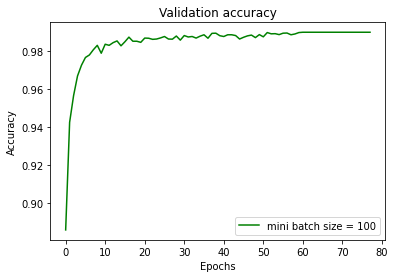

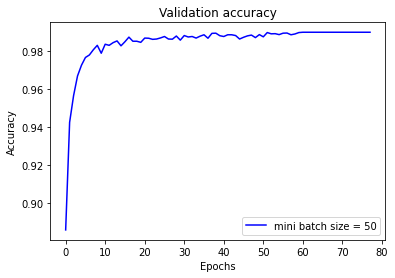

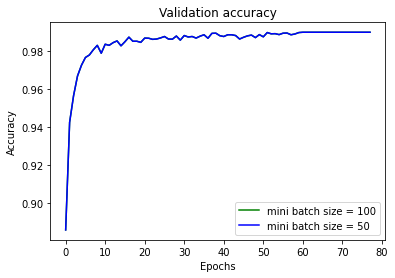

In [57]:
epochs = [i for i in range(0,max(iter_50,iter_100))]
if len(epochs) > len(acc_val_mean100):
  acc_val_mean100 = fill_list(acc_val_mean100,len(epochs))
if len(epochs) > len(acc_val_mean50):
  acc_val_mean100 = fill_list(acc_val_mean50,len(epochs))
plt.plot(epochs, acc_val_mean100, 'g', label='mini batch size = 100')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, acc_val_mean50, 'b', label='mini batch size = 50')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, acc_val_mean100, 'g', label='mini batch size = 100')
plt.plot(epochs, acc_val_mean50, 'b', label='mini batch size = 50')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**It can be seen (from the outputs / graph) that when the minibatch is 100 size it is more difficult for the network to converge, even though it started from a better starting point when the minibatch was 50 size.**

[Explanation above](https://stats.stackexchange.com/questions/316464/how-does-batch-size-affect-convergence-of-sgd-and-why)  

**I mean - the mini-batch-size = 100 graph is supposed to give a faster convergence, but for the sake of objectivity I re-initialized the weights for both of them and that's probably what made the difference. (In other experiments without rebooting the weights, and using the same model in both cases- a mini-batch-size = 100 converged faster, but it could be because I trained it before)**

In [43]:
arch_conv = [arch3,arch4,arch5]
best_arch = Architecture.get_arch_best_balanced_score(arch_conv)

balance accuracy:

#1=0.8442573919916413

#2=0.9195954145643904

#3=0.9312567844436483



## Chosen architecture: 
the architecture that gave the best balanced score was architecture #5 with the dropout fearure (decrease overfitting)

# Visualizing Filter & More -

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=3136, out_features=1024, bias=True)
  (9): ReLU()
  (10): Linear(in_features=1024, out_features=10, bias=True)
)


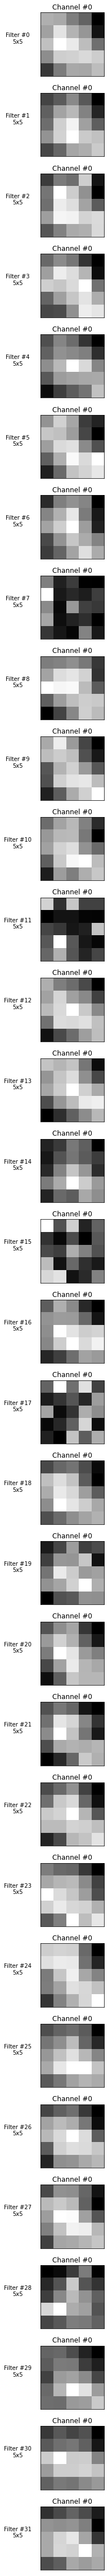

In [44]:
fig =Convolution_Func.visualize_filter(best_arch.model,'Conv2d', cmap='gray')
fig.show()

Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
torch.Size([32, 28, 28])
layer #0 feature maps...


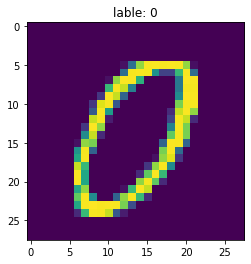

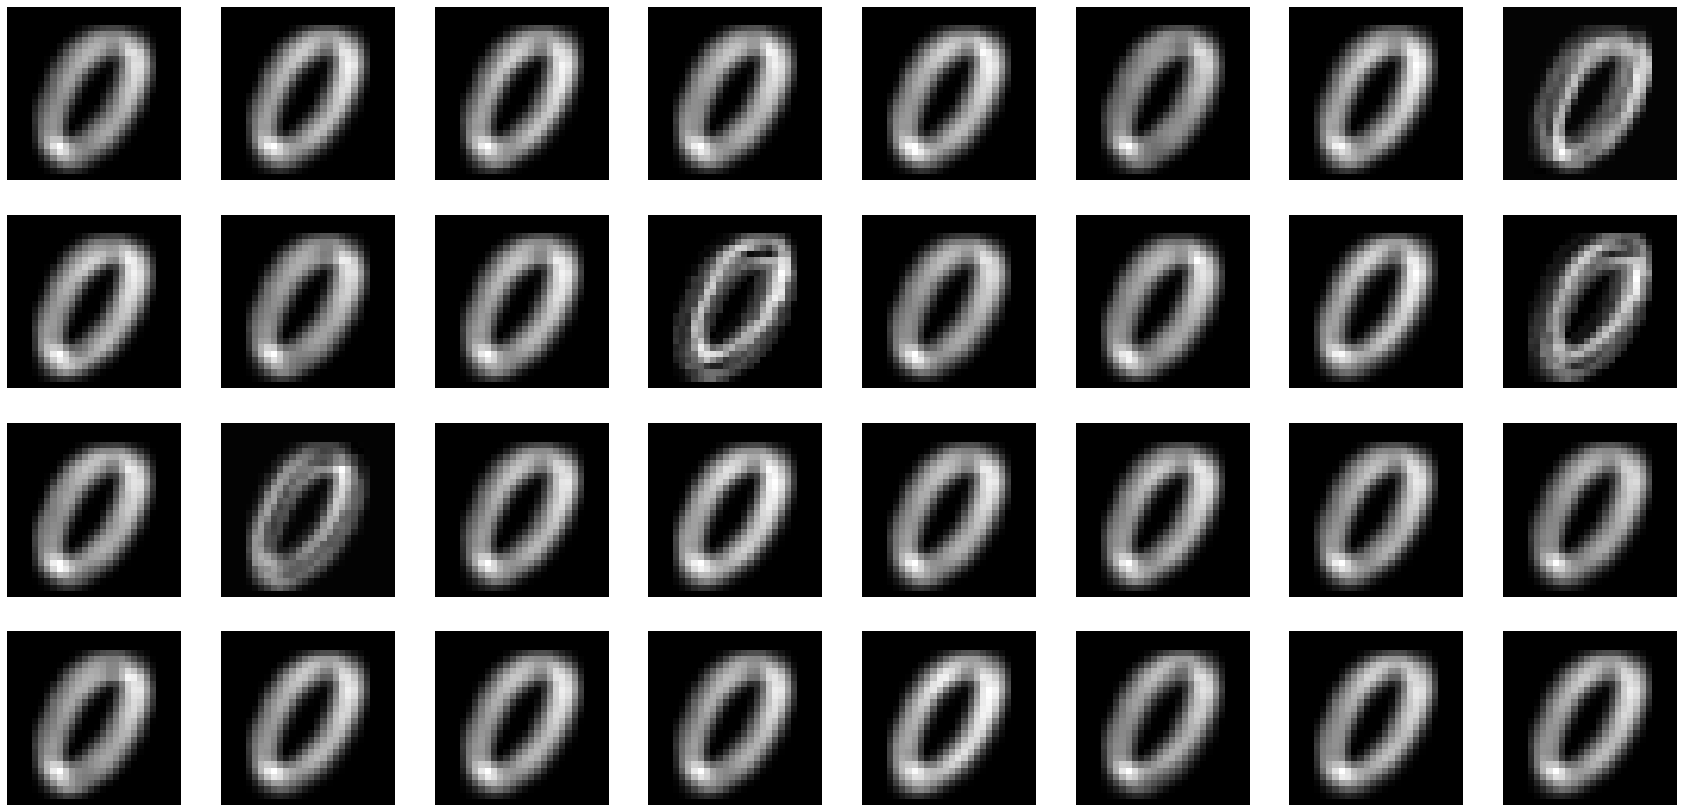

ReLU()
torch.Size([32, 28, 28])
layer #1 feature maps...


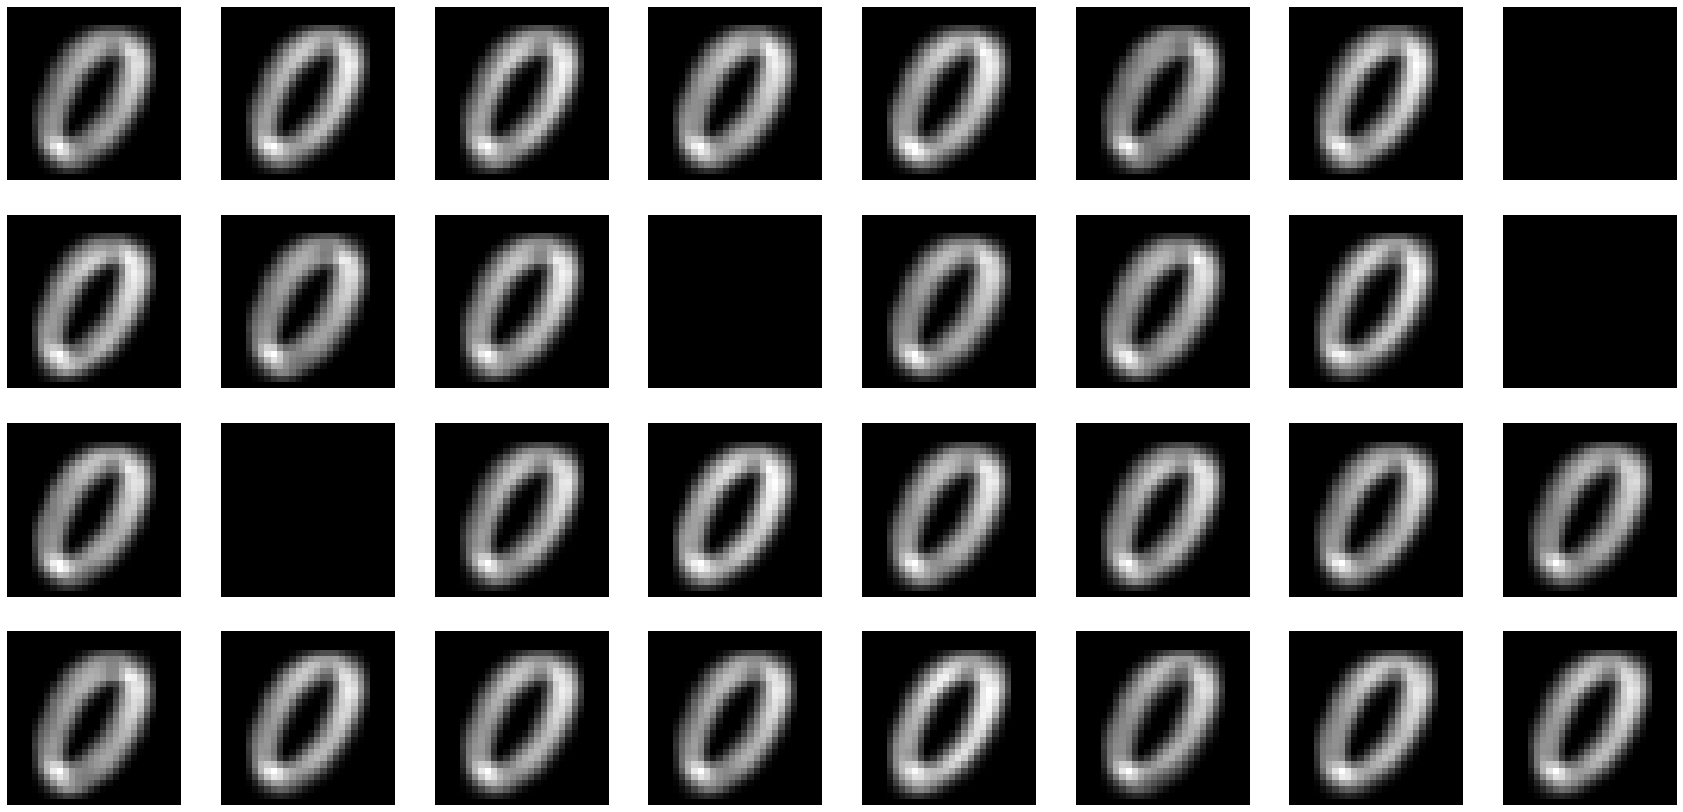

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([32, 14, 14])
layer #2 feature maps...


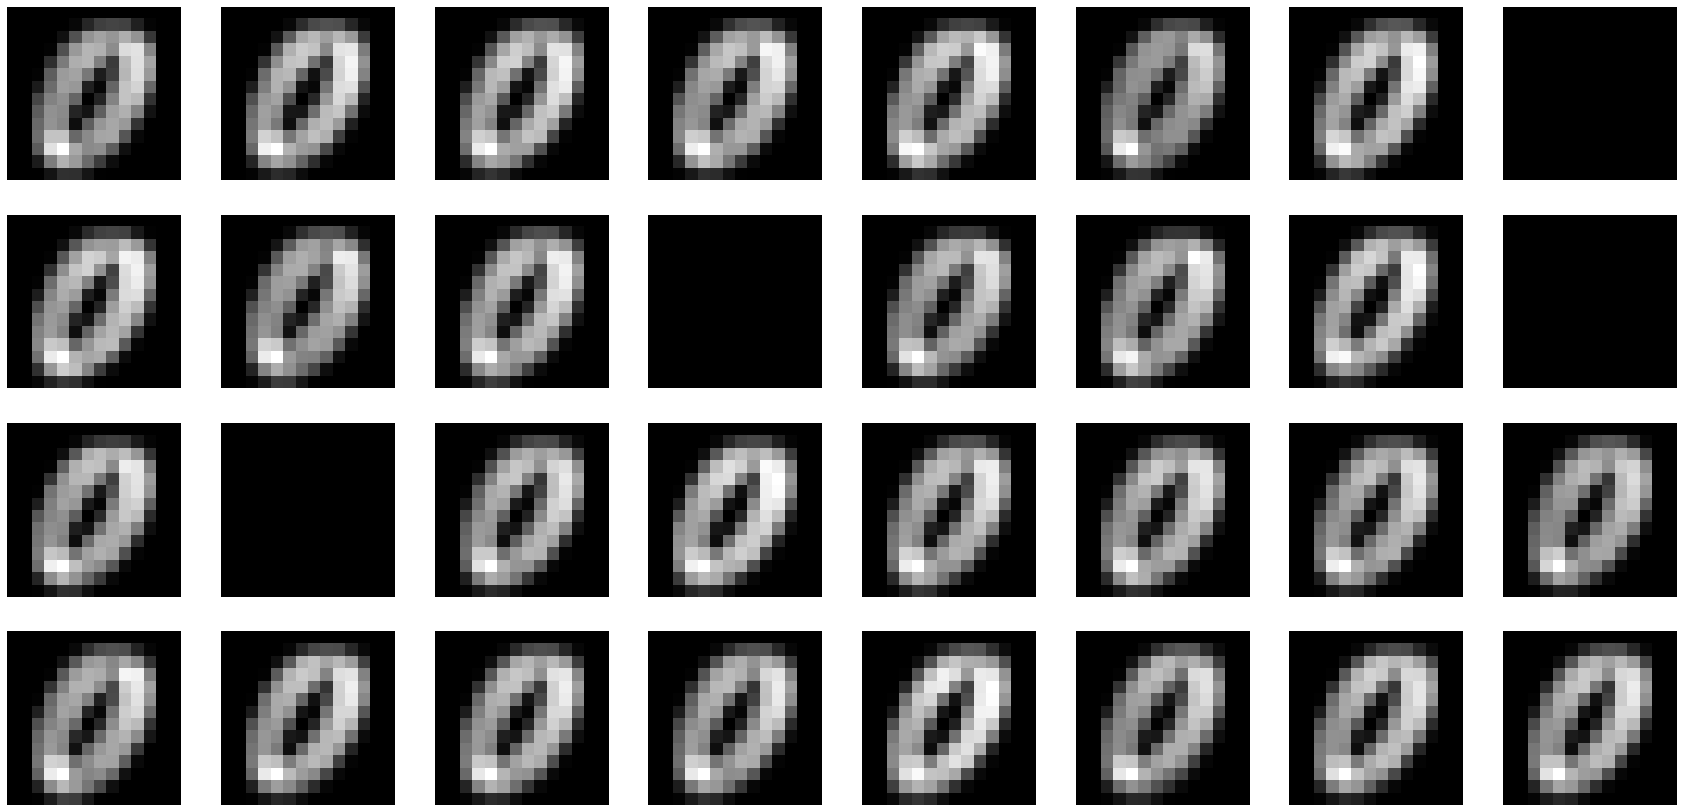

Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
torch.Size([64, 14, 14])
layer #3 feature maps...


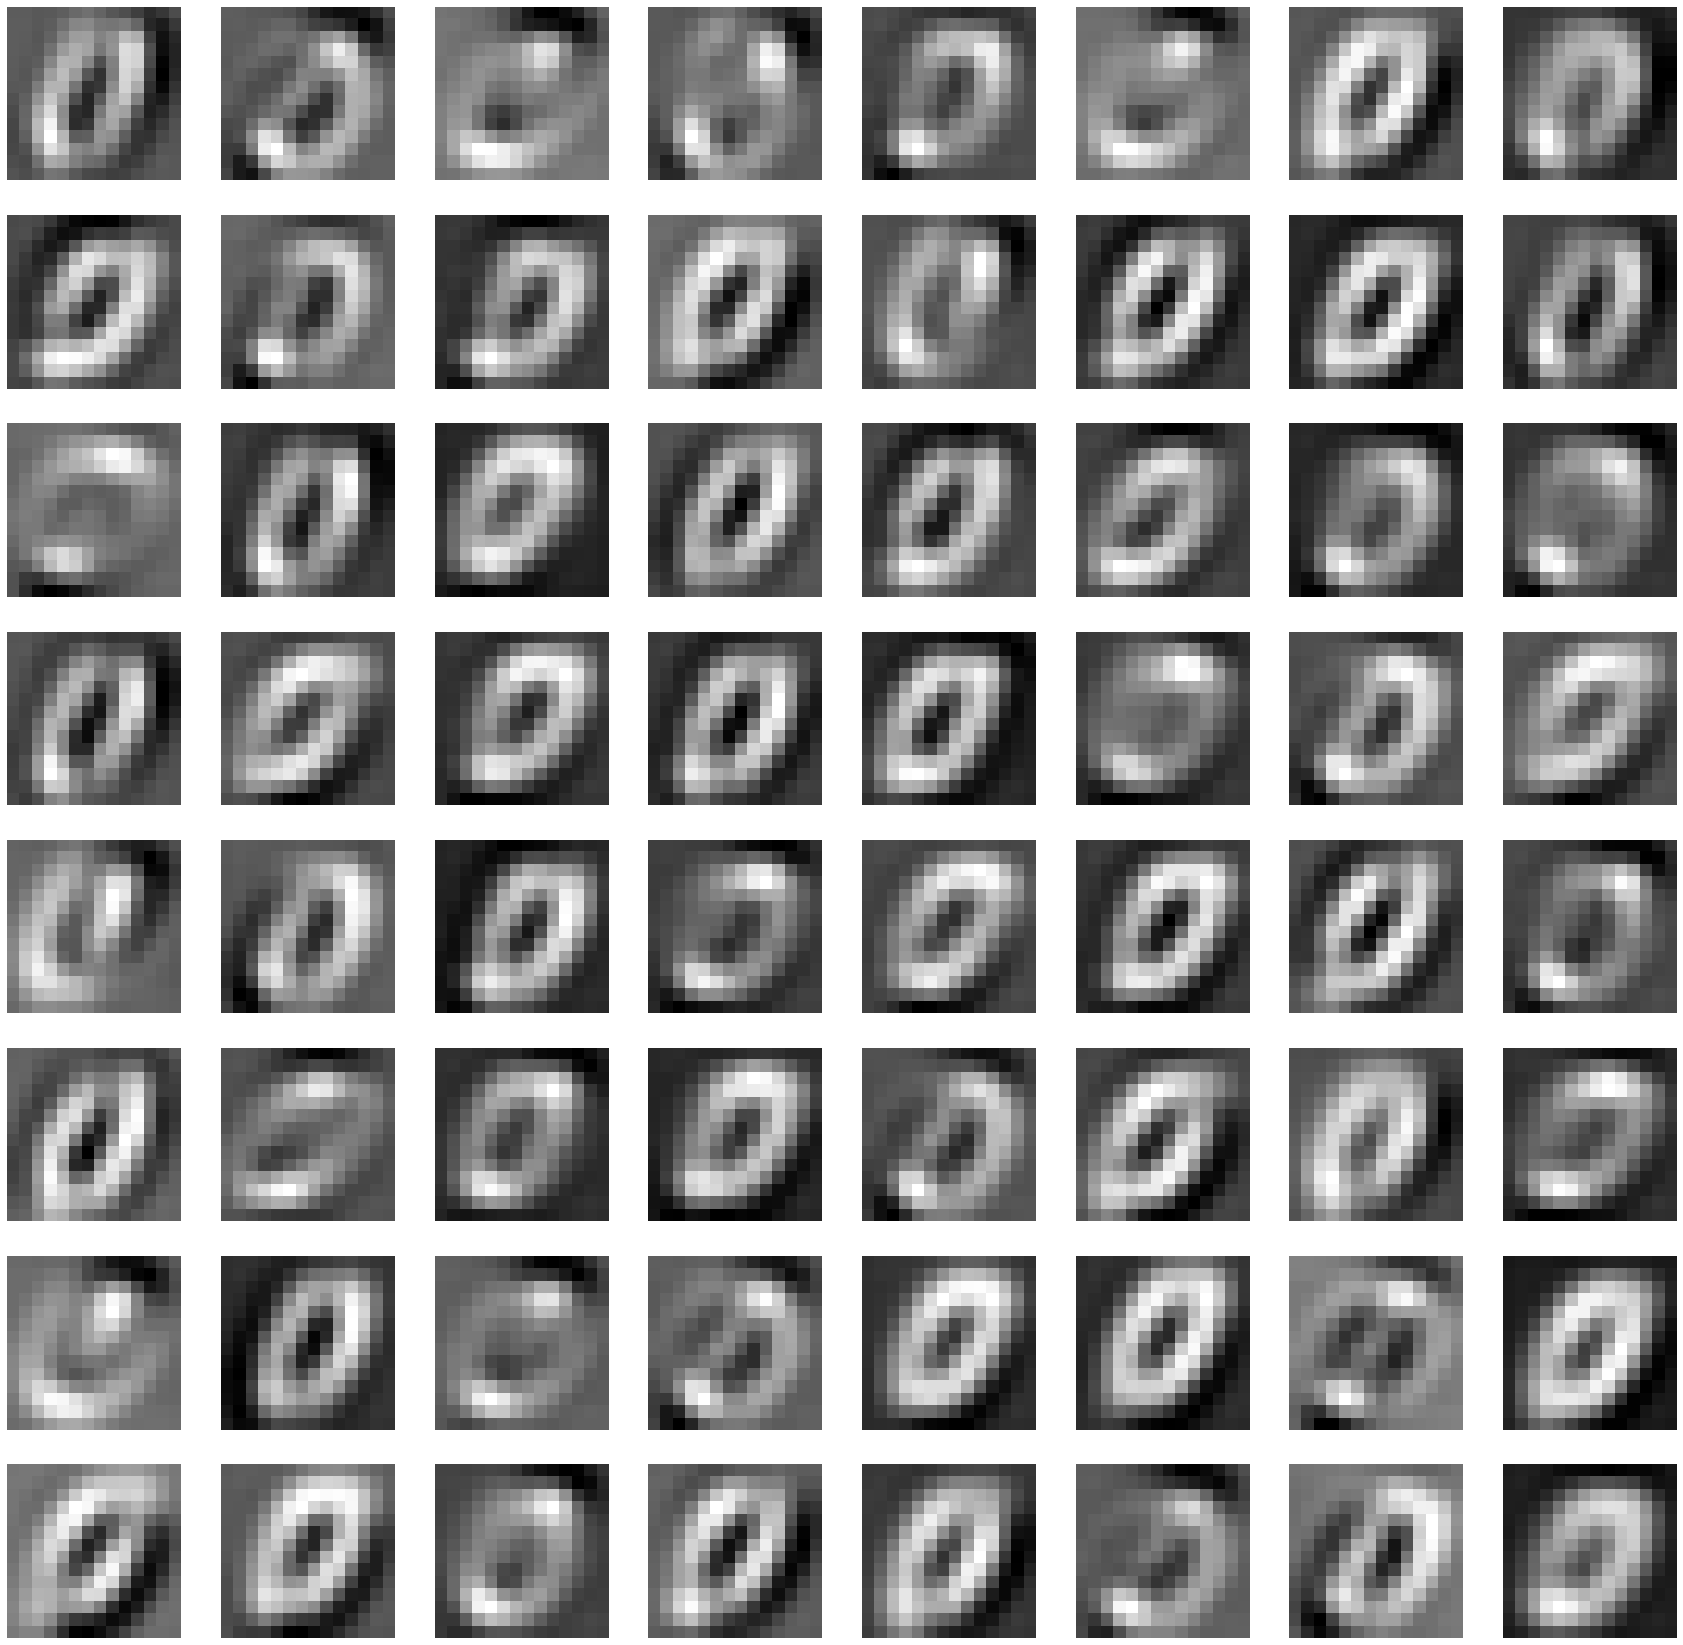

ReLU()
torch.Size([64, 14, 14])
layer #4 feature maps...


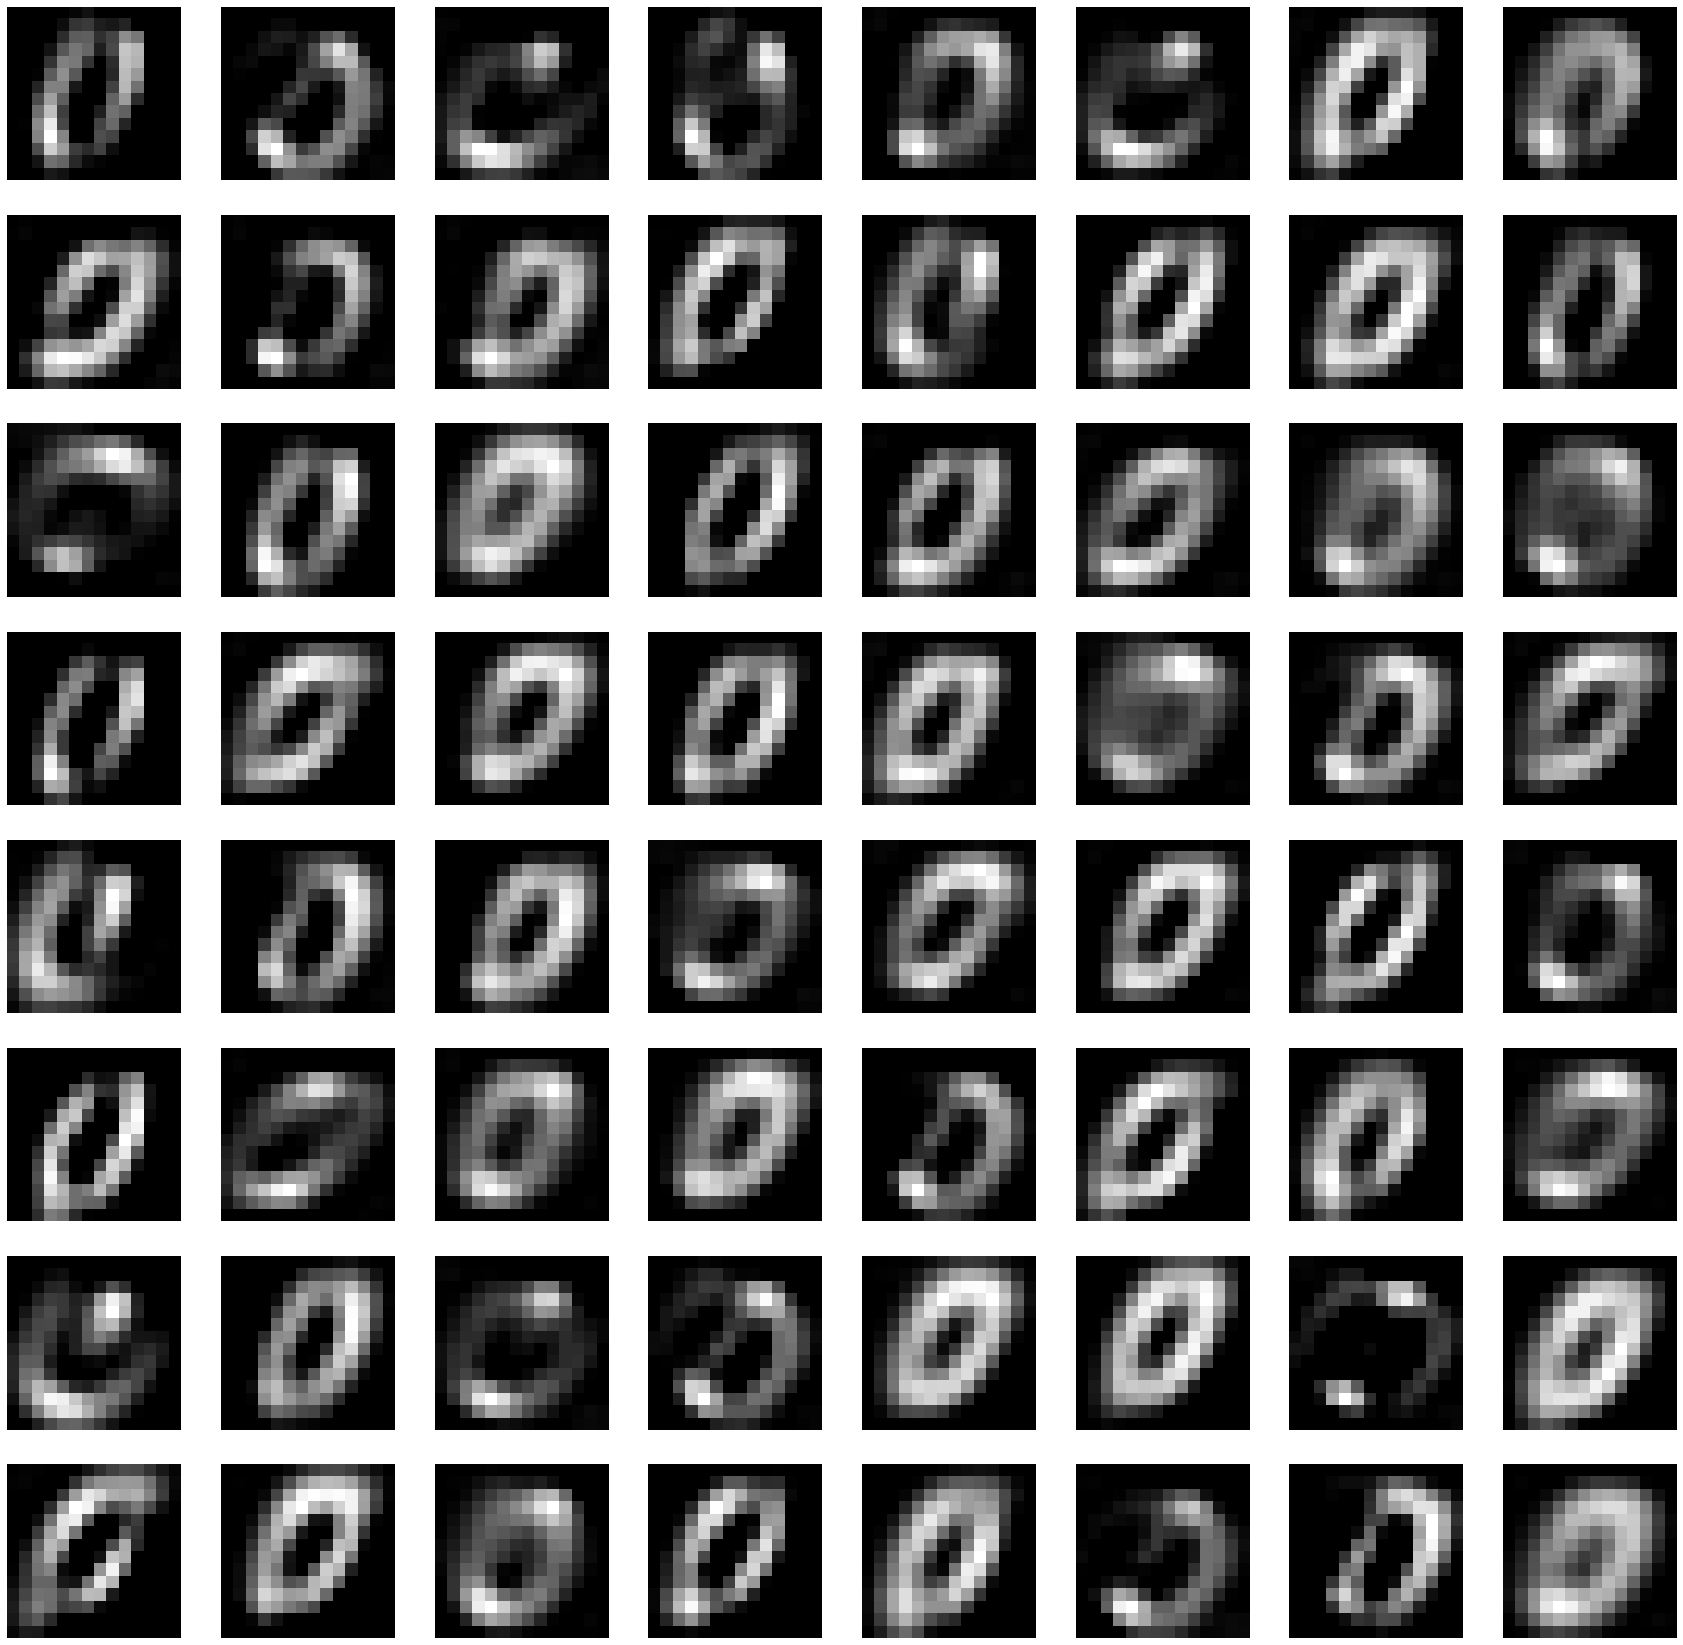

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([64, 7, 7])
layer #5 feature maps...


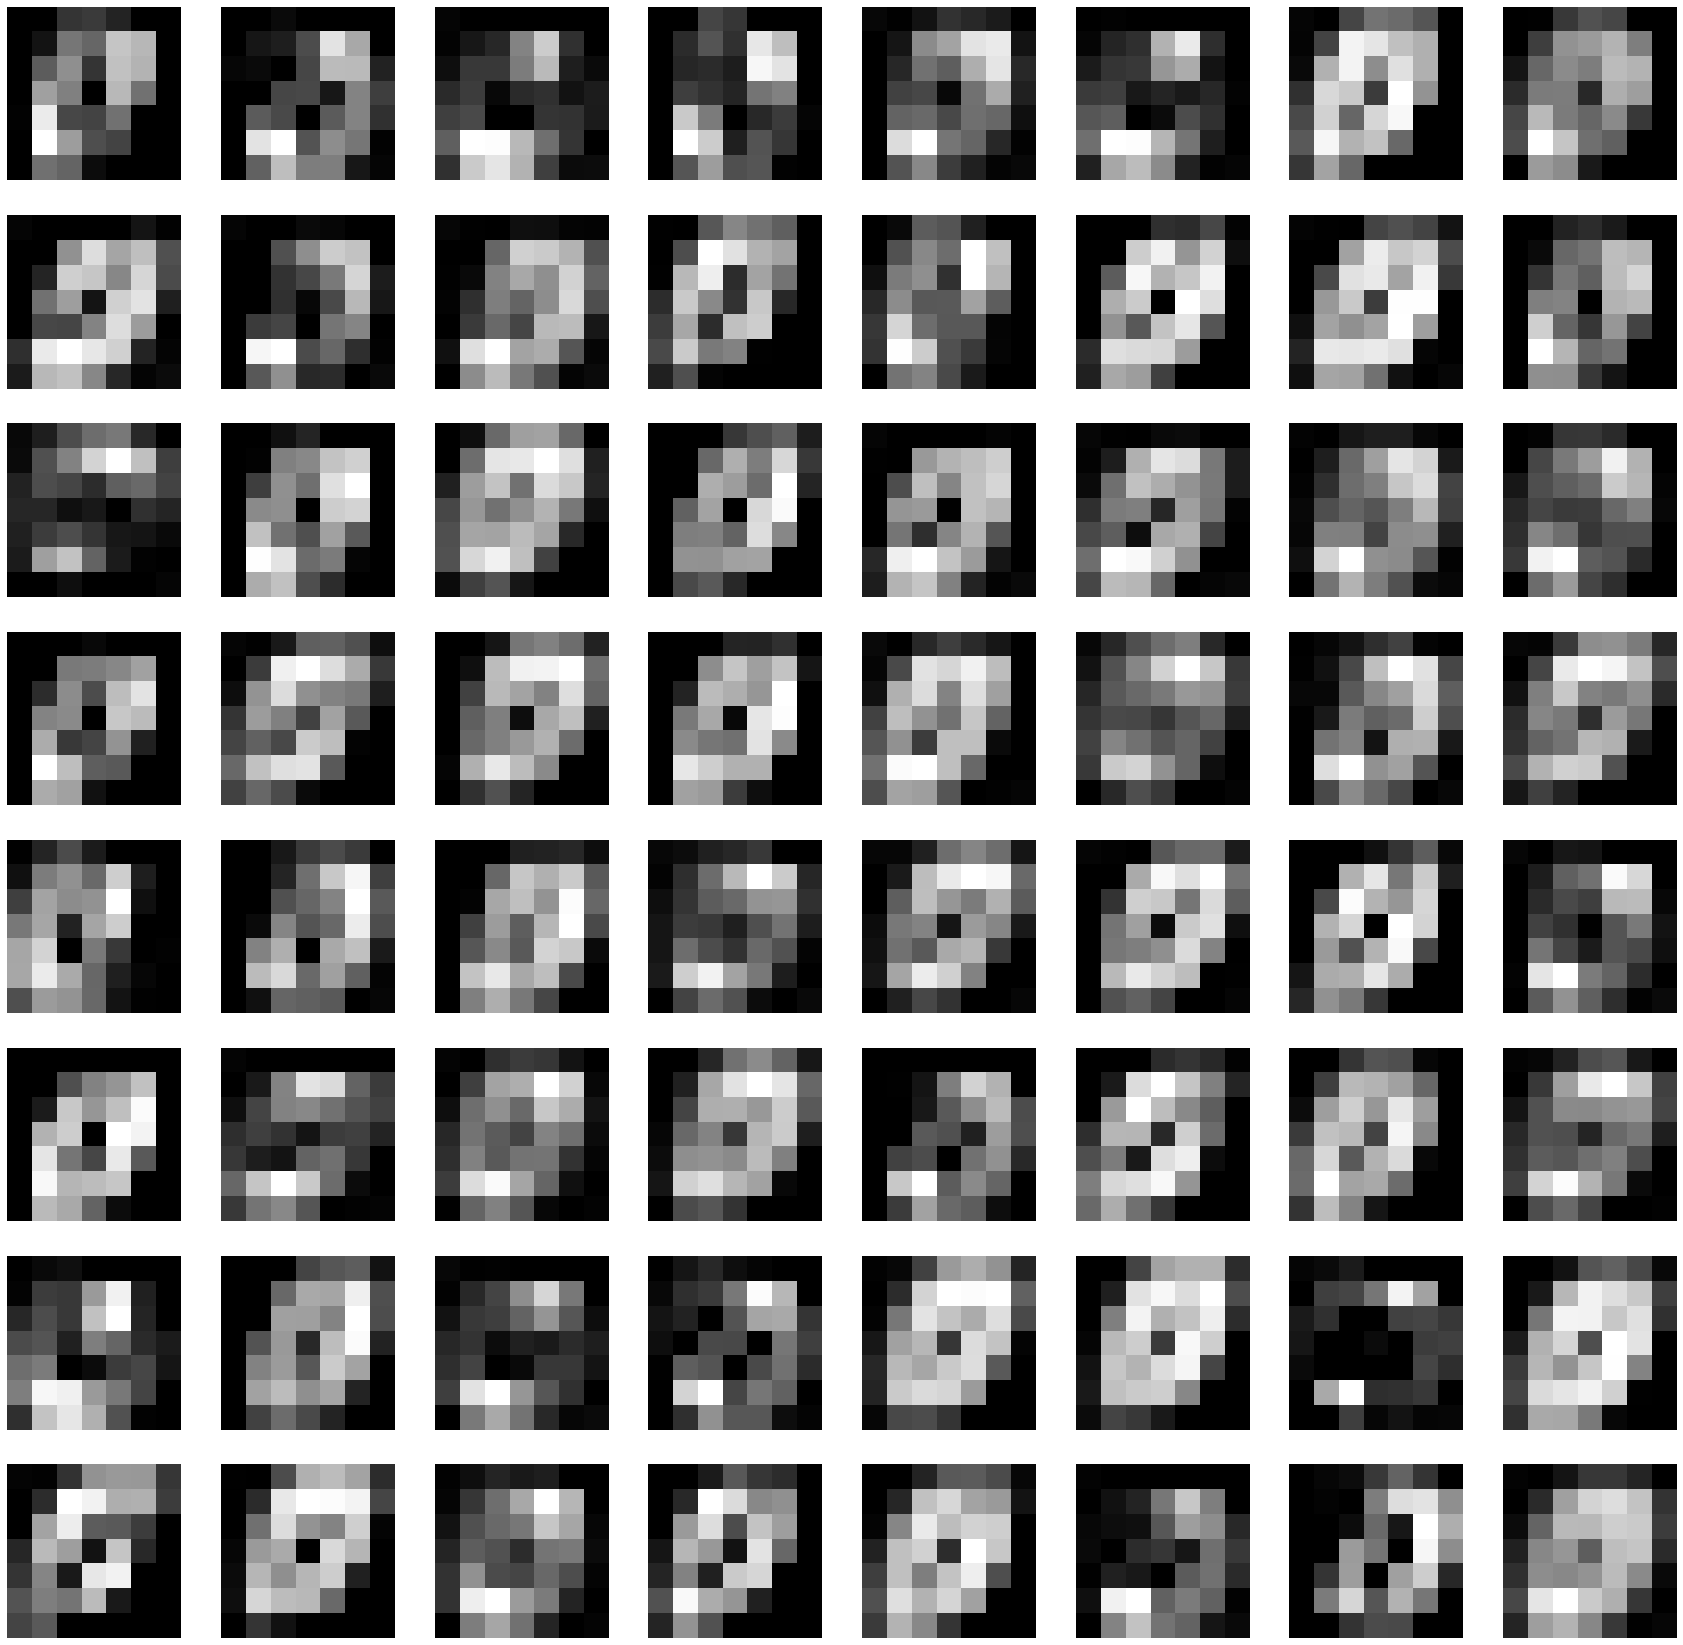

In [45]:
batch = next(iter(val_loader))
Convolution_Func.show_activation_map(batch,best_arch)

In [ ]:
print("""
|\    \ \ \ \ \ \ \      __   
|  \    \ \ \ \ \ \ \   | O~-_
|   >----|-|-|-|-|-|-|--|  __/  <The End!>
|  /    / / / / / / /   |__\  
|/     / / / / / / /""")

# Conclusion from the Assignment:    


## **Sample, Batch, Epoch**
* **What Is a Sample?**  
  * A sample is a single row of data:    
    * It contains inputs that are fed into the algorithm and an output that is used to compare to the prediction and calculate an error.  
    * A training dataset is comprised of many rows of data, e.g. many samples.
  * A sample may also be called an instance, an observation, an input vector, or a feature vector.
* **What Is a Batch?** 
  * The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
  * Think of a batch as a for-loop iterating over one or more samples and making predictions. At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient.
  * A training dataset can be divided into one or more batches.
  * Batch Gradient Descent. Batch Size = Size of Training Set  
Stochastic Gradient Descent. Batch Size = 1  
Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set  

[A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size  ](https://https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)
[How to Control the Speed and Stability of Training Neural Networks Batch Size](https://https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)

* What Is an Epoch?  
  * The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.  
    * One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters.
  * You can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified “batch size” number of samples.
    * The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized.

* What Is the Difference Between Batch and Epoch?  
  * The batch size is a number of samples processed before the model is updated.
  * The number of epochs is the number of complete passes through the training dataset.
  * The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.
  * The number of epochs can be set to an integer value between one and infinity. You can run the algorithm for as long as you like and even stop it using other criteria besides a fixed number of epochs, such as a change (or lack of change) in model error over time.
  * They are both integer values and they are both hyperparameters for the learning algorithm, e.g. parameters for the learning process, not internal model parameters found by the learning process.
* **Example batch VS. epoch VS. sample**:     
  * Assume you have a dataset with 200 samples (rows of data) and you choose a batch size of 5 and 1,000 epochs.
    * This means that the dataset will be divided into 40 batches, each with five samples. The model weights will be updated after each batch of five samples.
    * This also means that one epoch will involve 40 batches or 40 updates to the model.
    * With 1,000 epochs, the model will be exposed to or pass through the whole dataset 1,000 times. That is a total of 40,000 batches during the entire training process.

## TN,FP,FN,TP  

In [ ]:
totalPred =[0,0,0,0,0,0,0,0,0,0]
correctPred = [0,0,0,0,0,0,0,0,0,0]
incorrectPred = [0,0,0,0,0,0,0,0,0,0]
rates = np. zeros((10, 10))
for i,j in zip(arch1.Y_predict,arch1.T):
  rates[j][i]+=1
  totalPred[i]+=1
  if(i == j):
    correctPred[i]+=1
  else:
    incorrectPred[i]+=1
df = pd.DataFrame(rates)
precision = []
recall = []
fscore = []
df["sum"] = df.sum(axis=1)
for i in range(len(df)):
  df.at['Total', i] = df[i].sum()
for i in range(len(df)-1):
  precision.append((df.at[i, i]/df.at['Total', i]))
  recall.append(df.at[i, i]/df.at[i, 'sum'])
  #2*precision*recall/(precision+recall)
  fscore.append(2*((df.at[i, i]/df.at['Total', i])*(df.at[i, i]/df.at[i,'sum']))/((df.at[i, i]/df.at['Total', i])+(df.at[i, i]/df.at[i,'sum'])))
print(df)
print(f'Manually calculation:\nprecision = {np.mean(precision)}\nrecall = {np.mean(recall)}\n')
print(f'fscore = {np.mean(fscore)}\nAuto calculation:\n')


#short way
print(f'total = {totalPred}\ncorrect = {correctPred}\nincorrect = {incorrectPred}\n')
p = precision_score(arch1.T,arch1.Y_predict,average = 'macro')
r = recall_score(arch1.T,arch1.Y_predict,average = 'macro')
f = f1_score(arch1.T,arch1.Y_predict,average = 'macro')
print(f'precision ={p}\n')
print(f'recall = {r}\n')
print(f'f1 score = {f}\n')
print(f'accuracy = {accuracy_score(arch1.T,arch1.Y_predict)}\n')

         0    1    2    3    4    5       6    7        8    9     sum
0      0.0  0.0  0.0  0.0  0.0  0.0   886.0  0.0   3849.0  0.0  4735.0
1      0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0   5382.0  0.0  5383.0
2      0.0  0.0  0.0  0.0  0.0  0.0   586.0  0.0   4176.0  0.0  4762.0
3      0.0  0.0  0.0  0.0  0.0  0.0  1237.0  0.0   3649.0  0.0  4886.0
4      0.0  0.0  0.0  0.0  0.0  0.0   409.0  0.0   4272.0  0.0  4681.0
5      0.0  0.0  0.0  0.0  0.0  0.0   571.0  0.0   3797.0  0.0  4368.0
6      0.0  0.0  0.0  0.0  0.0  0.0   599.0  0.0   4153.0  0.0  4752.0
7      0.0  0.0  0.0  0.0  0.0  0.0   211.0  0.0   4772.0  0.0  4983.0
8      0.0  0.0  0.0  0.0  0.0  0.0   192.0  0.0   4482.0  0.0  4674.0
9      0.0  0.0  0.0  0.0  0.0  0.0   184.0  0.0   4592.0  0.0  4776.0
Total  0.0  0.0  0.0  0.0  0.0  0.0  4876.0  0.0  43124.0  0.0     NaN
Manually calculation:
precision = nan
recall = 0.10849738830322912

fscore = nan
Auto calculation:

total = [0, 0, 0, 0, 0, 0, 4876, 0, 43124, 0]
co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
